# Define configurations

In [2]:
user = 'participant1'
frequency = '15min' # 15min | 15s
dataset_type = '' # ''

if frequency == '15min':
    record_size_per_day = 96
elif frequency == '15s':
    record_size_per_day = 5760

# Columns to include    
if dataset_type == '':
    columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
            'time_from_last_drug_taken', 'wearing_off' ]

metrics = {
    'balanced_accuracy': 'Bal. Acc.',
    'f1_score': 'F1 Score',
    'accuracy': 'Acc.',
    'precision': 'Precision',
    'sensitivity': 'Recall / Sn',
    'specificity': 'Sp',
    'auc': 'AUC'
}

# Preparation

## Load libraries

In [3]:
from datetime import datetime
from datetime import timedelta
from typing import Union, Generator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

import sklearn
from photonai.base import Hyperpipe, PipelineElement, Stack, Switch
from photonai.optimization import FloatRange, IntegerRange, Categorical, BooleanSwitch, PhotonHyperparam
from photonai.optimization import Categorical as PhotonCategorical
from photonai.optimization import MinimumPerformanceConstraint, DummyPerformanceConstraint, BestPerformanceConstraint
from photonai.optimization.base_optimizer import PhotonSlaveOptimizer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

from skopt import Optimizer
from skopt.space import Real, Integer, Dimension
from skopt.space import Categorical as skoptCategorical
from photonai.photonlogger.logger import logger
from photonai.optimization.scikit_optimize.sk_opt import SkOptOptimizer

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning)
from photonai.base import Hyperpipe
from photonai.optimization import MinimumPerformanceConstraint
from photonai.photonlogger import logger 

## Load combined data

In [4]:
combined_data = pd.read_excel(f'./data/combined_data/{dataset_type}combined_data_{user}_{frequency}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
if dataset_type == '':
    # Define prediction horizon
    predict_ahead = pd.Timedelta(minutes=60)  # <- change to 2 or pd.Timedelta(seconds=15) as needed

    # Ensure datetime index
    combined_data = combined_data.sort_index()
    combined_data.index = pd.to_datetime(combined_data.index)

    # Estimate time delta between rows (assumes regular sampling)
    median_step = combined_data.index.to_series().diff().median()

    # How many steps to shift based on prediction horizon
    steps_ahead = int(predict_ahead / median_step)

    # Shift labels backward to align X at time t with y at t + n
    combined_data['wearing_off_future'] = combined_data['wearing_off'].shift(-steps_ahead)

    # Drop rows with NaNs from shifting
    combined_data = combined_data.dropna(subset=['wearing_off_future'])

    # Define X and y (keep X as DataFrame for .iloc to work)
    X = combined_data.loc[:, columns[1:-1]]  # or X = combined_data[feature_cols]
    y = combined_data['wearing_off_future'].astype(int).values


## Define Functions

In [5]:
# Show feature importances
def print_feature_importances(pipeline):
    output = ''
    if pipeline.optimum_pipe.feature_importances_ is None:
        output = 'Best Hyperparameter Configuration is a non-linear SVM, thus feature importances cannot be retrieved'
    else:
        output = 'Feature Importances using the Best Hyperparameter Config'
        if not [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE']:
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
        else:
            mask = [value.base_element.support_.tolist() for key, value in pipeline.optimum_pipe.elements if key == 'RFE'][0]
            if len(pipeline.optimum_pipe.feature_importances_) == 1:
                feature_importances = pipeline.optimum_pipe.feature_importances_[0]
            else:
                feature_importances = pipeline.optimum_pipe.feature_importances_
            output += '\n'
            output += tabulate(
                pd.DataFrame(
                    [np.around(feature_importances, decimals=4)],
                    columns=np.array(columns[1:-1])[mask]
                ).transpose().sort_values(by=[0], ascending=False, key=abs),
                tablefmt='psql', floatfmt=".4f", headers=['Features', 'Values']
            )
    return output

In [6]:
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


In [7]:
def plot_confusion_matrix_from_pipeline(pipeline):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(
        pipeline.results_handler.get_test_predictions()['y_true'],
        pipeline.results_handler.get_test_predictions()['y_pred'],
        labels=[0,1], normalize=None)
    ax = plt.subplot()
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'25'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    # title_font = {'size':'21'}  # Adjust to fit
    # ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=25)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Good', 'Wearing-Off']);
    ax.yaxis.set_ticklabels(['Good', 'Wearing-Off']);
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    # plt.savefig('./participant2-downsampling-confusionmatrix-real.pdf', bbox_inches='tight')
    plt.show()

In [8]:
# Write other reports to summary file
def add_other_report_to_summary(pipeline, with_estimator_comparison=True):
    with open(f'{pipeline.output_settings.results_folder}/photon_summary.txt', "a+") as summary_file:
        # 1. Write comparison of learning algorithms
        if with_estimator_comparison:
            summary_file.write("\n\n")
            summary_file.write("Comparison on learning algorithms on validation set")
            summary_file.write("\n")
            summary_file.write(str(pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator()))

        # 2. Write feature importance
        summary_file.write("\n\n")
        summary_file.write("Feature Importance")
        summary_file.write(print_feature_importances(pipeline))
        
        # 3. Write beautified average test performance across outer folds
        # a. Get Average Test Performance Across Outer Folds
        test_metric_result = pipeline.results.get_test_metric_dict()
        
        # b. Replace display metric name
        #   Reference: https://stackoverflow.com/a/55250496/2303766
        test_metric_result = { metrics[metric]: test_metric_result[metric]
                                  for metric, metric_name in metrics.items() if metric in test_metric_result
                             }
        
        # c. Add beautified average test performance across outer folds to file 
        summary_file.write("\n\n")
        summary_file.write("Average Test Performance Across Outer Folds")
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(
                    test_metric_result
                ).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )
        
        # 4. Write outer fold results
        summary_file.write("\n\n")
        summary_file.write("Outer Fold Best Estimators' Performance")
        summary_file.write("\n")
        handler = pipeline.results_handler
        performance_table = handler.get_performance_table()
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold', 'best_config', 'n_train', 'n_validation']].transpose(),
                    tablefmt='psql', headers='keys'
                )
            )
            summary_file.write("\n")
            summary_file.write(
                tabulate(
                    performance_table.loc[:, ['fold'] + list(metrics.keys())].round(4).transpose(),
                    tablefmt='psql', floatfmt=".4f", headers='keys'
                )
            )
            
        outer_fold_performance = {}
        config_evals = handler.get_config_evaluations()
        for metric in metrics.keys():
            # print(f'{metric}')
            for i, j in enumerate(config_evals[metric]):
                if f'{metric}_mean' in outer_fold_performance:
                    # outer_fold_performance[f'{metric}_max'].append(np.max(j))
                    outer_fold_performance[f'{metric}_mean'].append(np.mean(j))
                    outer_fold_performance[f'{metric}_std'].append(np.std(j))
                else:
                    # outer_fold_performance[f'{metric}_max'] = [np.max(j)]
                    outer_fold_performance[f'{metric}_mean'] = [np.mean(j)]
                    outer_fold_performance[f'{metric}_std'] = [np.std(j)]
        summary_file.write("\n")
        summary_file.write(
            tabulate(
                pd.DataFrame(outer_fold_performance).round(4).transpose(),
                tablefmt='psql', floatfmt=".4f", headers='keys'
            )
        )

In [9]:
# PhotonAI Optimize Monkey-patch
#     Added random_state for Optimize for result replicability
def prepare(self, pipeline_elements: list, maximize_metric: bool) -> None:
    """
    Initializes hyperparameter search with scikit-optimize.

    Assembles all hyperparameters of the list of PipelineElements
    in order to prepare the hyperparameter space.
    Hyperparameters can be accessed via pipe_element.hyperparameters.

    Parameters:
        pipeline_elements:
            List of all PipelineElements to create the hyperparameter space.

        maximize_metric:
            Boolean to distinguish between score and error.

    """
    self.start_time = None
    self.optimizer = None
    self.hyperparameter_list = []
    self.maximize_metric = maximize_metric

    # build skopt space
    space = []
    for pipe_element in pipeline_elements:
        if pipe_element.__class__.__name__ == 'Switch':
            error_msg = 'Scikit-Optimize cannot operate in the specified hyperparameter space with a Switch ' \
                        'element. We recommend the use of SMAC.'
            logger.error(error_msg)
            raise ValueError(error_msg)

        if hasattr(pipe_element, 'hyperparameters'):
            for name, value in pipe_element.hyperparameters.items():
                # if we only have one value we do not need to optimize
                if isinstance(value, list) and len(value) < 2:
                    self.constant_dictionary[name] = value[0]
                    continue
                if isinstance(value, PhotonCategorical) and len(value.values) < 2:
                    self.constant_dictionary[name] = value.values[0]
                    continue
                skopt_param = self._convert_photonai_to_skopt_space(value, name)
                if skopt_param is not None:
                    space.append(skopt_param)

    if self.constant_dictionary:
        msg = "PHOTONAI has detected some one-valued params in your hyperparameters. Pleas use the kwargs for " \
              "constant values. This run ignores following settings: " + str(self.constant_dictionary.keys())
        logger.warning(msg)
        warnings.warn(msg)

    if len(space) == 0:
        msg = "Did not find any hyperparameter to convert into skopt space."
        logger.warning(msg)
        warnings.warn(msg)
    else:
        self.optimizer = Optimizer(space,
                                   base_estimator=self.base_estimator,
                                   n_initial_points=self.n_initial_points,
                                   initial_point_generator=self.initial_point_generator,
                                   acq_func=self.acq_func,
                                   acq_func_kwargs=self.acq_func_kwargs,
                                   random_state=4
                                  )
    self.ask = self.ask_generator()
    
#    Monkey patched new prepare function
SkOptOptimizer.prepare = prepare

## Visualize Data Split

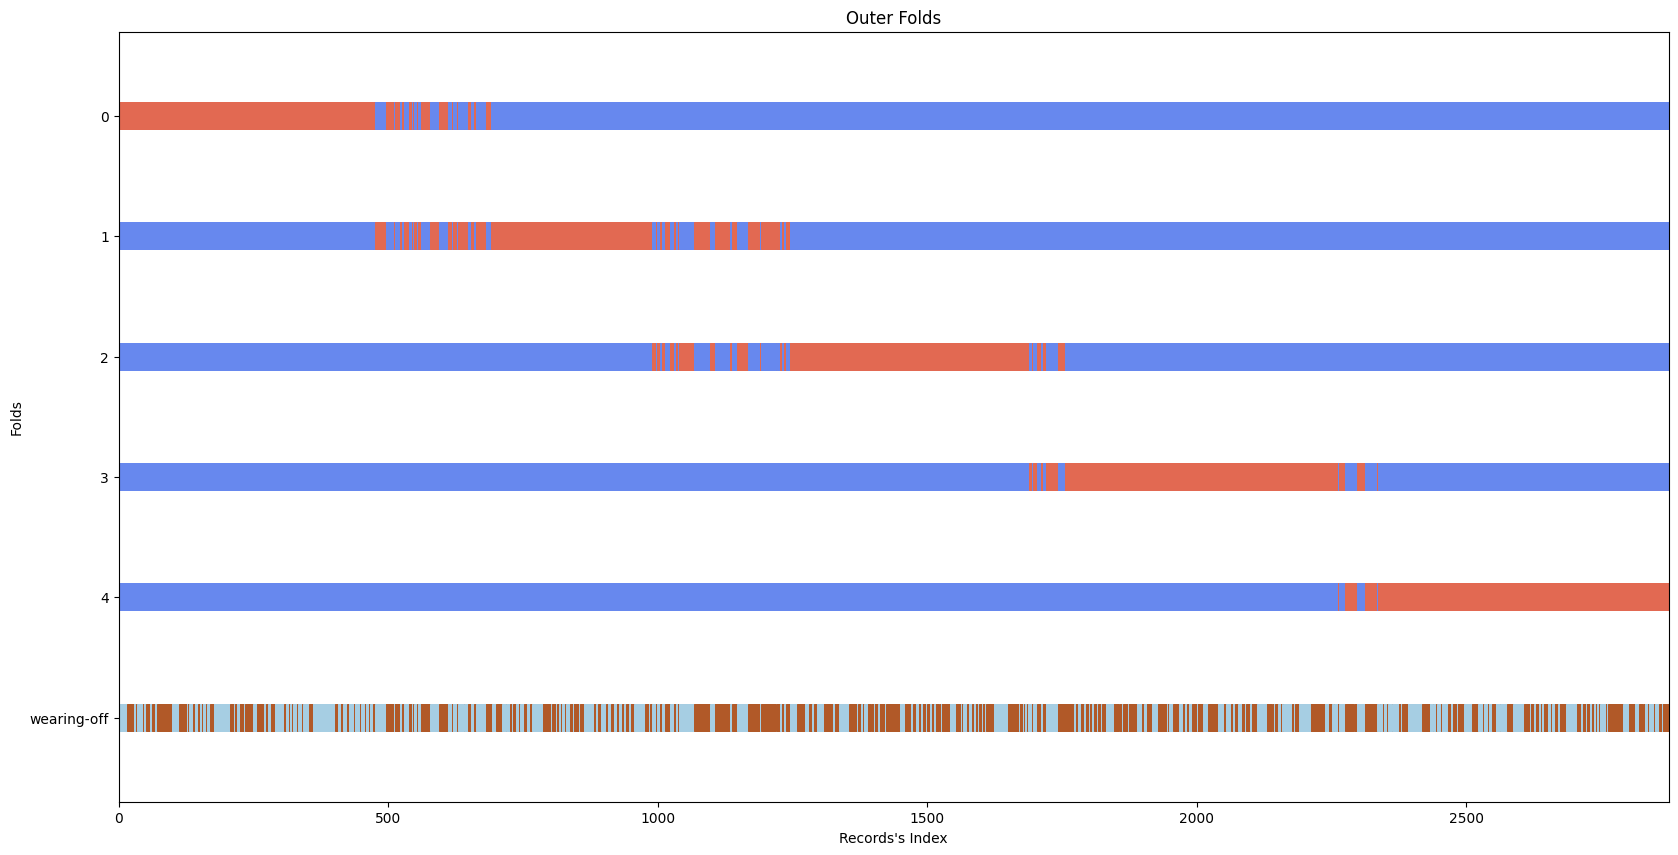

Train Set for Outer Fold 0
[ 479  484  485 ... 2873 2874 2875]

Train Set for Outer Fold 1
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 2
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 3
[   0    1    2 ... 2873 2874 2875]

Train Set for Outer Fold 4
[   0    1    2 ... 2319 2343 2344]



In [10]:
# Outer CV
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=5, shuffle=False)
plot_cv_indices(cv, X, y, ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title('Outer Folds')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

training_folds = []
for train, test in cv.split(X, y):
    print(f'Train Set for Outer Fold {len(training_folds)}')
    print(train)
    training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

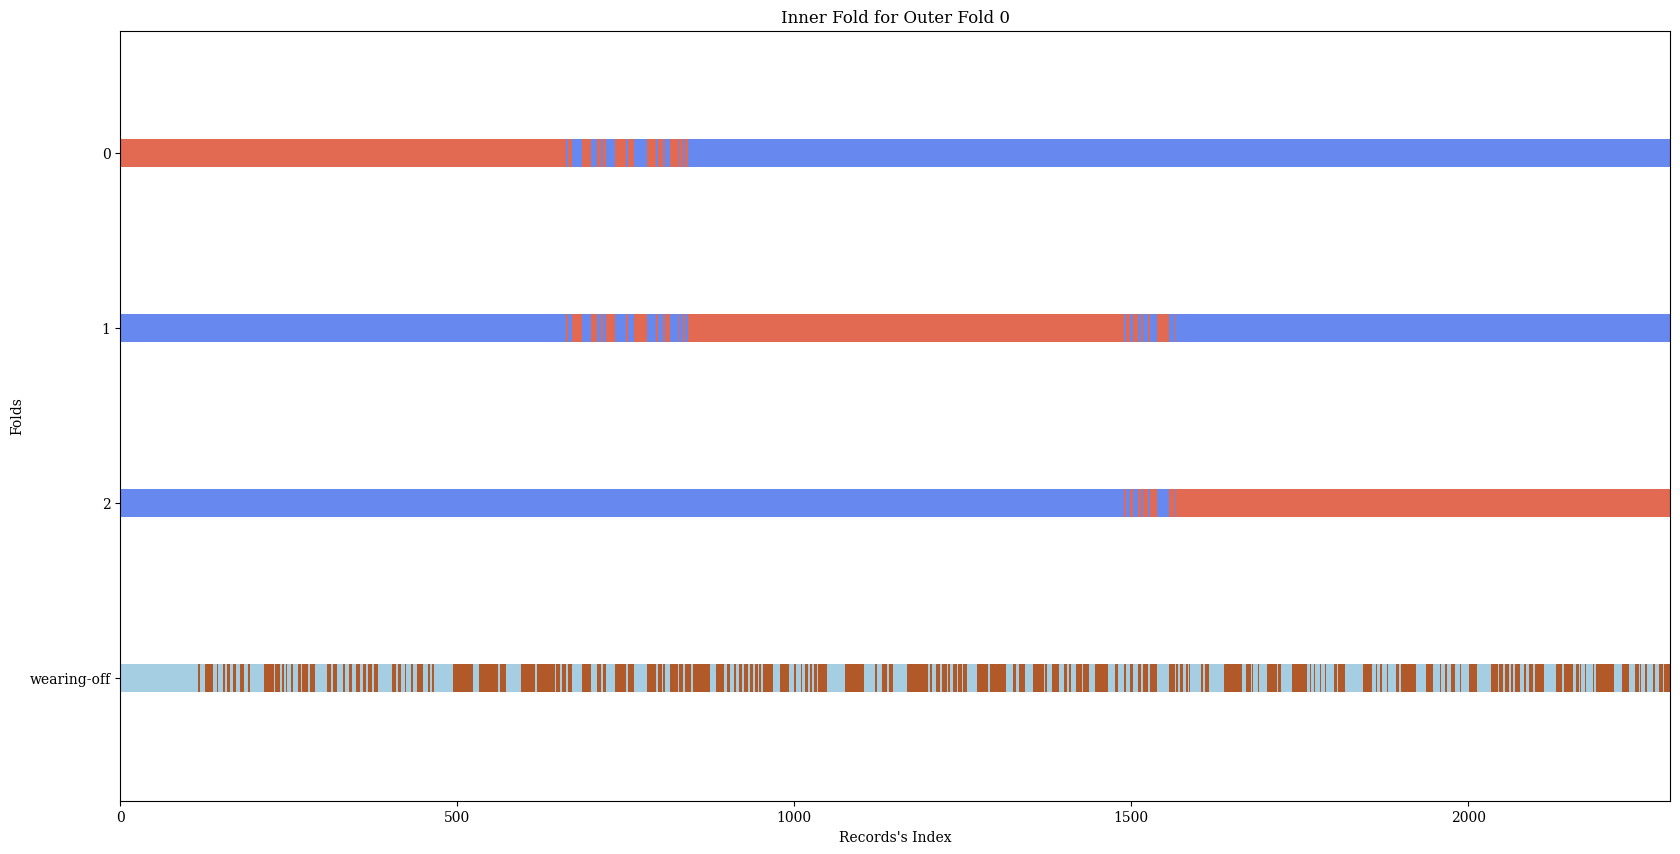

Train Sets for Outer Fold 0
Train Set for Inner Fold 0
[ 661  667  668 ... 2297 2298 2299]

Train Set for Inner Fold 1
[   0    1    2 ... 2297 2298 2299]

Train Set for Inner Fold 2
[   0    1    2 ... 1561 1571 1575]



In [11]:
# Inner CV
outer_fold_number = 0

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(20,10))
cv = StratifiedKFold(n_splits=3, shuffle=False)
plot_cv_indices(cv, X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]], ax)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
plt.title(f'Inner Fold for Outer Fold {outer_fold_number}')
# Save as file
# plt.savefig('./blockingtimeseriessplit.pdf', bbox_inches='tight')
plt.show()

inner_training_folds = []
print(f'Train Sets for Outer Fold {outer_fold_number}')
for train, test in cv.split(X.iloc[training_folds[outer_fold_number]], y[training_folds[outer_fold_number]]):
    print(f'Train Set for Inner Fold {len(inner_training_folds)}')
    print(train)
    inner_training_folds.append(train)
    # print("Test")
    # print(test[0], test[-1])
    print()

# Pipeline

## Define learning algorithms

In [12]:
estimator_selection = Switch('estimators')
estimator_selection += PipelineElement("LogisticRegression",
                           hyperparameters={
                               'C': FloatRange(1, 10)
                           }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement("DecisionTreeClassifier",
                           hyperparameters={
                               'min_samples_split': IntegerRange(2,30),
                               'min_samples_leaf': IntegerRange(2,30)
                           }, random_state=4, criterion='gini')
estimator_selection += PipelineElement('LinearSVC',
                            hyperparameters={
                                'C': FloatRange(1, 25)
                            }, class_weight='balanced', random_state=4)
estimator_selection += PipelineElement('RandomForestClassifier', 
                            hyperparameters={
                                'min_samples_split': IntegerRange(2,30),
                                'max_features': ['auto', 'sqrt', 'log2']
                            }, random_state=4, criterion='gini', bootstrap=True)
estimator_selection += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            }, random_state=4)

## Initial Pipeline

In [13]:
initial_pipeline = Hyperpipe('1 - Initial Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

# Add learning algorithms to compare
initial_pipeline += estimator_selection

# Fit hyperpipe
initial_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(initial_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(initial_pipeline)

# # View CV splits for debugging
# for k,v in initial_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(initial_pipeline)

13/06/2025-14:51:07 | Output Folder: ./analysis/participant1_15min\1InitialPipeline_results_2025-06-13_14-51-07
PHOTONAI ANALYSIS: 1InitialPipeline
13/06/2025-14:51:07 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-14:51:07 | Checking input data...
13/06/2025-14:51:07 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
13/06/2025-14:51:07 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-14:51:07 | Preparing data for outer fold 1...
13/06/2025-14:51:07 | Preparing Hyperparameter Optimization...
13/06/2025-14:51:07 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "LogisticRegression__C=9.105593099632042",
        "estimator_n

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:51:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:26 | Computed configuration 96/150 in 0:00:00.233349
13/06/2025-14:51:26 | Performance:             balanced_accuracy - Train: 0.8300, Validation: 0.5111
13/06/2025-14:51:26 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:27 | Computed configuration 97/150 in 0:00:00.266700
13/06/2025-14:51:27 | Performance:             balanced_accuracy - Train: 0.9700, Validation: 0.4891
13/06/2025-14:51:27 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:28 | Computed configuration 102/150 in 0:00:00.249888
13/06/2025-14:51:28 | Performance:             balanced_accuracy - Train: 0.8430, Validation: 0.4784
13/06/2025-14:51:28 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:29 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=13",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:31 | Computed configuration 109/150 in 0:00:00.254955
13/06/2025-14:51:31 | Performance:             balanced_accuracy - Train: 0.8931, Validation: 0.4940
13/06/2025-14:51:31 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:32 | Computed configuration 111/150 in 0:00:00.244250
13/06/2025-14:51:32 | Performance:             balanced_accuracy - Train: 0.9081, Validation: 0.4824
13/06/2025-14:51:32 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:33 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:35 | Computed configuration 117/150 in 0:00:00.254792
13/06/2025-14:51:35 | Performance:             balanced_accuracy - Train: 0.8808, Validation: 0.4848
13/06/2025-14:51:35 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:36 | Computed configuration 119/150 in 0:00:00.266635
13/06/2025-14:51:36 | Performance:             balanced_accuracy - Train: 0.9551, Validation: 0.4955
13/06/2025-14:51:36 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:51:36 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:51:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:37 | Computed configuration 125/150 in 0:00:00.266493
13/06/2025-14:51:37 | Performance:             balanced_accuracy - Train: 0.7819, Validation: 0.5401
13/06/2025-14:51:37 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:51:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:38 | Computed configuration 129/150 in 0:00:00.233206
13/06/2025-14:51:38 | Performance:             balanced_accuracy - Train: 0.6951, Validation: 0.5623
13/06/2025-14:51:38 | Best Performance So Far: balanced_accuracy - Train: 0.7970, Validation: 0.5744
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:51:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:51:38 | Computed configuration 130/150 in 0:00:00.243327
13/06/2025-14:51:38 | Performance:             balanced_accuracy - Train: 0.8776, Validation: 0.5162
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:52:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:07 | Computed configuration 96/150 in 0:00:00.233368
13/06/2025-14:52:07 | Performance:             balanced_accuracy - Train: 0.8380, Validation: 0.5130
13/06/2025-14:52:07 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:08 | Computed configuration 97/150 in 0:00:00.266552
13/06/2025-14:52:08 | Performance:             balanced_accuracy - Train: 0.9675, Validation: 0.5080
13/06/2025-14:52:08 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:09 | Computed configuration 102/150 in 0:00:00.266691
13/06/2025-14:52:09 | Performance:             balanced_accuracy - Train: 0.9544, Validation: 0.5108
13/06/2025-14:52:09 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=26",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:10 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:13 | Computed configuration 110/150 in 0:00:00.234397
13/06/2025-14:52:13 | Performance:             balanced_accuracy - Train: 0.8854, Validation: 0.5291
13/06/2025-14:52:13 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:14 | Computed configuration 112/150 in 0:00:00.250057
13/06/2025-14:52:14 | Performance:             balanced_accuracy - Train: 0.9128, Validation: 0.5211
13/06/2025-14:52:14 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=28",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:15 | Computed configuration 114/150 in 0:00:00.233338
13/06/2025-14:52:15 | Performance:             balanced_accuracy - Train: 0.8672, Validation: 0.5067
13/06/2025-14:52:15 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:15 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:52:19 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:19 | Computed configuration 125/150 in 0:00:00.250057
13/06/2025-14:52:19 | Performance:             balanced_accuracy - Train: 0.7808, Validation: 0.4772
13/06/2025-14:52:19 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:52:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:20 | Computed configuration 129/150 in 0:00:00.233259
13/06/2025-14:52:20 | Performance:             balanced_accuracy - Train: 0.6973, Validation: 0.4842
13/06/2025-14:52:20 | Best Performance So Far: balanced_accuracy - Train: 0.8652, Validation: 0.5481
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:52:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:20 | Computed configuration 130/150 in 0:00:00.233207
13/06/2025-14:52:20 | Performance:             balanced_accuracy - Train: 0.8764, Validation: 0.5047
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:52:50 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:50 | Computed configuration 96/150 in 0:00:00.233438
13/06/2025-14:52:50 | Performance:             balanced_accuracy - Train: 0.8587, Validation: 0.5003
13/06/2025-14:52:50 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:51 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:51 | Computed configuration 97/150 in 0:00:00.283337
13/06/2025-14:52:51 | Performance:             balanced_accuracy - Train: 0.9713, Validation: 0.4952
13/06/2025-14:52:51 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:52 | Computed configuration 102/150 in 0:00:00.249966
13/06/2025-14:52:52 | Performance:             balanced_accuracy - Train: 0.8672, Validation: 0.4913
13/06/2025-14:52:52 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:53 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:56 | Computed configuration 109/150 in 0:00:00.250074
13/06/2025-14:52:56 | Performance:             balanced_accuracy - Train: 0.9329, Validation: 0.4912
13/06/2025-14:52:56 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:56 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:56 | Computed configuration 111/150 in 0:00:00.216652
13/06/2025-14:52:56 | Performance:             balanced_accuracy - Train: 0.8450, Validation: 0.5043
13/06/2025-14:52:56 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:57 | Computed configuration 113/150 in 0:00:00.250023
13/06/2025-14:52:57 | Performance:             balanced_accuracy - Train: 0.8860, Validation: 0.5043
13/06/2025-14:52:57 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:58 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:52:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:52:59 | Computed configuration 117/150 in 0:00:00.250087
13/06/2025-14:52:59 | Performance:             balanced_accuracy - Train: 0.8984, Validation: 0.5002
13/06/2025-14:52:59 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:00 | Computed configuration 119/150 in 0:00:00.266619
13/06/2025-14:53:00 | Performance:             balanced_accuracy - Train: 0.9635, Validation: 0.5030
13/06/2025-14:53:00 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:01 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:53:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:02 | Computed configuration 125/150 in 0:00:00.250014
13/06/2025-14:53:02 | Performance:             balanced_accuracy - Train: 0.8151, Validation: 0.5196
13/06/2025-14:53:02 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:53:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:02 | Computed configuration 129/150 in 0:00:00.250048
13/06/2025-14:53:02 | Performance:             balanced_accuracy - Train: 0.6551, Validation: 0.5284
13/06/2025-14:53:02 | Best Performance So Far: balanced_accuracy - Train: 0.8527, Validation: 0.5385
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:53:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:02 | Computed configuration 130/150 in 0:00:00.249949
13/06/2025-14:53:02 | Performance:             balanced_accuracy - Train: 0.9030, Validation: 0.5262
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:53:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:32 | Computed configuration 96/150 in 0:00:00.249958
13/06/2025-14:53:32 | Performance:             balanced_accuracy - Train: 0.8550, Validation: 0.5397
13/06/2025-14:53:32 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:33 | Computed configuration 97/150 in 0:00:00.266697
13/06/2025-14:53:33 | Performance:             balanced_accuracy - Train: 0.9760, Validation: 0.5267
13/06/2025-14:53:33 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:34 | Computed configuration 102/150 in 0:00:00.249977
13/06/2025-14:53:34 | Performance:             balanced_accuracy - Train: 0.9409, Validation: 0.5438
13/06/2025-14:53:34 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=5",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:35 | Skipped f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:37 | Computed configuration 109/150 in 0:00:00.234416
13/06/2025-14:53:37 | Performance:             balanced_accuracy - Train: 0.8674, Validation: 0.5334
13/06/2025-14:53:37 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:38 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:39 | Computed configuration 112/150 in 0:00:00.233397
13/06/2025-14:53:39 | Performance:             balanced_accuracy - Train: 0.8674, Validation: 0.5334
13/06/2025-14:53:39 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:39 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:42 | Computed configuration 118/150 in 0:00:00.233403
13/06/2025-14:53:42 | Performance:             balanced_accuracy - Train: 0.8342, Validation: 0.5412
13/06/2025-14:53:42 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:53:43 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:53:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:44 | Computed configuration 125/150 in 0:00:00.233384
13/06/2025-14:53:44 | Performance:             balanced_accuracy - Train: 0.8094, Validation: 0.5385
13/06/2025-14:53:44 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:53:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:45 | Computed configuration 129/150 in 0:00:00.248223
13/06/2025-14:53:45 | Performance:             balanced_accuracy - Train: 0.6976, Validation: 0.4756
13/06/2025-14:53:45 | Best Performance So Far: balanced_accuracy - Train: 0.7543, Validation: 0.5543
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:53:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:53:45 | Computed configuration 130/150 in 0:00:00.233335
13/06/2025-14:53:45 | Performance:             balanced_accuracy - Train: 0.9013, Validation: 0.5647
13/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:54:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:16 | Computed configuration 96/150 in 0:00:00.235206
13/06/2025-14:54:16 | Performance:             balanced_accuracy - Train: 0.8479, Validation: 0.4971
13/06/2025-14:54:16 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:16 | Computed configuration 97/150 in 0:00:00.266746
13/06/2025-14:54:16 | Performance:             balanced_accuracy - Train: 0.9746, Validation: 0.4976
13/06/2025-14:54:16 | Best Pe

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=22",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:17 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:17 | Computed configuration 102/150 in 0:00:00.216707
13/06/2025-14:54:17 | Performance:             balanced_accuracy - Train: 0.8642, Validation: 0.4960
13/06/2025-14:54:17 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=21",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:18 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:21 | Computed configuration 109/150 in 0:00:00.250050
13/06/2025-14:54:21 | Performance:             balanced_accuracy - Train: 0.9324, Validation: 0.4949
13/06/2025-14:54:21 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:22 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:22 | Computed configuration 111/150 in 0:00:00.231529
13/06/2025-14:54:22 | Performance:             balanced_accuracy - Train: 0.8460, Validation: 0.4922
13/06/2025-14:54:22 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:23 | Computed configuration 113/150 in 0:00:00.233356
13/06/2025-14:54:23 | Performance:             balanced_accuracy - Train: 0.8836, Validation: 0.4946
13/06/2025-14:54:23 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:23 | Skipped

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:24 | Computed configuration 117/150 in 0:00:00.233344
13/06/2025-14:54:24 | Performance:             balanced_accuracy - Train: 0.8947, Validation: 0.5025
13/06/2025-14:54:24 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter o

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=7",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:25 | Computed configuration 119/150 in 0:00:00.250057
13/06/2025-14:54:25 | Performance:             balanced_accuracy - Train: 0.9603, Validation: 0.5132
13/06/2025-14:54:25 | Best Performance So Far: balanced_accuracy - Train: 0.9151, Validation: 0.5556
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:54:26 | Skipped 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:54:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:27 | Computed configuration 125/150 in 0:00:00.250067
13/06/2025-14:54:27 | Performance:             balanced_accuracy - Train: 0.8042, Validation: 0.5444
13/06/2025-14:54:27 | Best Performance So Far: balanced_accuracy - Train: 0.7854, Validation: 0.5614
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.05212780929227985",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:54:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:27 | Computed configuration 129/150 in 0:00:00.229653
13/06/2025-14:54:27 | Performance:             balanced_accuracy - Train: 0.6956, Validation: 0.5471
13/06/2025-14:54:27 | Best Performance So Far: balanced_accuracy - Train: 0.7854, Validation: 0.5614
-----------------------------------------------------------------------------------------------------
{
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.2711354491499446",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:54:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:54:28 | Computed configuration 130/150 in 0:00:00.250029
13/06/2025-14:54:28 | Performance:             balanced_accuracy - Train: 0.8972, Validation: 0.5330
13/

## Feature Selection Pipeline

In [14]:
classifier = LogisticRegression(random_state=4).fit(X, y)

feature_selection_pipeline = Hyperpipe('2 - Feature Selection Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

feature_selection_pipeline += estimator_selection

# Fit hyperpipe
feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(feature_selection_pipeline)

13/06/2025-14:54:40 | Output Folder: ./analysis/participant1_15min\2FeatureSelectionPipline_results_2025-06-13_14-54-40
PHOTONAI ANALYSIS: 2FeatureSelectionPipline
13/06/2025-14:54:40 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-14:54:40 | Checking input data...
13/06/2025-14:54:40 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
JsonTransformer was unable to create the .json file.
13/06/2025-14:54:40 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-14:54:40 | Preparing data for outer fold 1...
13/06/2025-14:54:40 | Preparing Hyperparameter Optimization...
13/06/2025-14:54:40 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:02 | Computed configuration 96/150 in 0:00:00.235052
13/06/2025-14:55:02 | Performance:             balanced_accuracy - Train: 0.8430, Validation: 0.5042
13/06/2025-14:55:02 | Best Performance So Far: balanced_accuracy - Train: 0.7963, Validation: 0.5768
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:55:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:02 | Computed configuration 97/150 in 0:00:00.216807
13/06/2025-14:55:02 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:02 | Computed configuration 100/150 in 0:00:00.249950
13/06/2025-14:55:02 | Performance:             balanced_accuracy - Train: 0.8300, Validation: 0.5111
13/06/2025-14:55:02 | Best Performance So Far: balanced_accuracy - Train: 0.7963, Validation: 0.5768
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:55:03 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:03 | Computed configuration 101/150 in 0:00:00.150096
13/06/2025-14:55:03 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:13 | Computed configuration 122/150 in 0:00:00.233524
13/06/2025-14:55:13 | Performance:             balanced_accuracy - Train: 0.6672, Validation: 0.5045
13/06/2025-14:55:13 | Best Performance So Far: balanced_accuracy - Train: 0.7963, Validation: 0.5768
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:13 | Computed configuration 125/150 in 0:00:00.182746
13/06/2025-14:55:13 | Performance:             balanced_accuracy - Train: 0.6434, Validation: 0.5122
13/06/2025-14:55:13 | Best Performance So Far: balanced_accuracy - Train: 0.7963, Validation: 0.5768
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:13 | Computed configuration 127/150 in 0:00:00.176623
13/06/2025-14:55:13 | Performance:             balanced_accuracy - Train: 0.6383, Validation: 0.5116
13/06/2025-14:55:13 | Best Performance So Far: balanced_accuracy - Train: 0.7963, Validation: 0.5768
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:55:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:14 | Computed configuration 128/150 in 0:00:00.152871
13/06/2025-14:55:14 | Performance:             balanced_accuracy - Train: 0.5692, Validation: 0.4987
13/06/2025-14:55:14 | Best Performance So Far: balanced_accuracy - T

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:55:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:14 | Computed configuration 131/150 in 0:00:00.134334
13/06/2025-14:55:14 | Performance:             balanced_accuracy - Train: 0.5961, Validation: 0.4215
13/06/2025-14:55:14 | Best Performance So Far: balanced_accuracy - Train: 0.7963, Validation: 0.5768
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:47 | Computed configuration 96/150 in 0:00:00.266702
13/06/2025-14:55:47 | Performance:             balanced_accuracy - Train: 0.8431, Validation: 0.5094
13/06/2025-14:55:47 | Best Performance So Far: balanced_accuracy - Train: 0.8172, Validation: 0.5247
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:55:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:47 | Computed configuration 97/150 in 0:00:00.215660
13/06/2025-14:55:47 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:47 | Computed configuration 100/150 in 0:00:00.233345
13/06/2025-14:55:47 | Performance:             balanced_accuracy - Train: 0.8380, Validation: 0.5130
13/06/2025-14:55:47 | Best Performance So Far: balanced_accuracy - Train: 0.8172, Validation: 0.5247
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:55:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:48 | Computed configuration 101/150 in 0:00:00.150058
13/06/2025-14:55:48 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=29",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:55:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:53 | Computed configuration 113/150 in 0:00:00.216700
13/06/2025-14:55:53 | Performance:             balanced_accuracy - Train: 0.8198, Validation: 0.5249
13/06/2025-14:55:53 | Best Performance So Far: balanced_accuracy - Train: 0.8198, Validation: 0.5249
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:55:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:54 | Computed configuration 116/150 in 0:00:00.216740
13/06/2025-14:55:54 | Performance:             balanced_accuracy - Train: 0.7579, Validation: 0.5002
13/06/2025-14:55:54 | Best Performance So Far: balanced_accuracy - Train: 0.8198, Validation: 0.5249
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=3"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:57 | Computed configuration 122/150 in 0:00:00.200050
13/06/2025-14:55:57 | Performance:             balanced_accuracy - Train: 0.6353, Validation: 0.4868
13/06/2025-14:55:57 | Best Performance So Far: balanced_accuracy - Train: 0.8198, Validation: 0.5249
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:55:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:57 | Computed configuration 127/150 in 0:00:00.150051
13/06/2025-14:55:57 | Performance:             balanced_accuracy - Train: 0.6345, Validation: 0.4340
13/06/2025-14:55:57 | Best Performance So Far: balanced_accuracy - Train: 0.8198, Validation: 0.5249
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:55:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:57 | Computed configuration 128/150 in 0:00:00.166711
13/06/2025-14:55:57 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:55:58 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:55:58 | Computed configuration 131/150 in 0:00:00.114677
13/06/2025-14:55:58 | Performance:             balanced_accuracy - Train: 0.5973, Validation: 0.3832
13/06/2025-14:55:58 | Best Performance So Far: balanced_accuracy - Train: 0.8198, Validation: 0.5249
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:56:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:30 | Computed configuration 96/150 in 0:00:00.233425
13/06/2025-14:56:30 | Performance:             balanced_accuracy - Train: 0.8672, Validation: 0.4913
13/06/2025-14:56:30 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:56:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:31 | Computed configuration 97/150 in 0:00:00.249995
13/06/2025-14:56:31 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:56:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:31 | Computed configuration 100/150 in 0:00:00.249984
13/06/2025-14:56:31 | Performance:             balanced_accuracy - Train: 0.8587, Validation: 0.5003
13/06/2025-14:56:31 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:56:31 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:31 | Computed configuration 101/150 in 0:00:00.200026
13/06/2025-14:56:31 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:56:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:35 | Computed configuration 108/150 in 0:00:00.250079
13/06/2025-14:56:35 | Performance:             balanced_accuracy - Train: 0.9186, Validation: 0.4888
13/06/2025-14:56:35 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, jo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:56:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:42 | Computed configuration 122/150 in 0:00:00.218576
13/06/2025-14:56:42 | Performance:             balanced_accuracy - Train: 0.6210, Validation: 0.5233
13/06/2025-14:56:42 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:56:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:42 | Computed configuration 125/150 in 0:00:00.197769
13/06/2025-14:56:42 | Performance:             balanced_accuracy - Train: 0.6950, Validation: 0.5285
13/06/2025-14:56:42 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:56:42 | Computed configuration 127/150 in 0:00:00.182185
13/06/2025-14:56:42 | Performance:             balanced_accuracy - Train: 0.6486, Validation: 0.5233
13/06/2025-14:56:42 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:56:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:42 | Computed configuration 128/150 in 0:00:00.183429
13/06/2025-14:56:42 | Performance:             balanced_accuracy - Train: 0.6104, Validation: 0.5075
13/06/2025-14:56:42 | Best Performance So Far: balanced_accuracy - T

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:56:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:56:43 | Computed configuration 131/150 in 0:00:00.148039
13/06/2025-14:56:43 | Performance:             balanced_accuracy - Train: 0.7507, Validation: 0.4703
13/06/2025-14:56:43 | Best Performance So Far: balanced_accuracy - Train: 0.7176, Validation: 0.5869
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:57:15 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:15 | Computed configuration 96/150 in 0:00:00.259059
13/06/2025-14:57:15 | Performance:             balanced_accuracy - Train: 0.8674, Validation: 0.5334
13/06/2025-14:57:15 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:57:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:16 | Computed configuration 97/150 in 0:00:00.233709
13/06/2025-14:57:16 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:57:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:16 | Computed configuration 100/150 in 0:00:00.249207
13/06/2025-14:57:16 | Performance:             balanced_accuracy - Train: 0.8550, Validation: 0.5397
13/06/2025-14:57:16 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:57:16 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:16 | Computed configuration 101/150 in 0:00:00.215751
13/06/2025-14:57:16 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:57:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:23 | Computed configuration 114/150 in 0:00:00.232553
13/06/2025-14:57:23 | Performance:             balanced_accuracy - Train: 0.8623, Validation: 0.5266
13/06/2025-14:57:23 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:57:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:25 | Computed configuration 118/150 in 0:00:00.209439
13/06/2025-14:57:25 | Performance:             balanced_accuracy - Train: 0.7818, Validation: 0.4837
13/06/2025-14:57:25 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:57:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:26 | Computed configuration 122/150 in 0:00:00.223036
13/06/2025-14:57:26 | Performance:             balanced_accuracy - Train: 0.6837, Validation: 0.4693
13/06/2025-14:57:26 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:57:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:27 | Computed configuration 125/150 in 0:00:00.189903
13/06/2025-14:57:27 | Performance:             balanced_accuracy - Train: 0.6973, Validation: 0.5218
13/06/2025-14:57:27 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.06194436878055191",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:57:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:27 | Computed configuration 127/150 in 0:00:00.203809
13/06/2025-14:57:27 | Performance:             balanced_accuracy - Train: 0.6832, Validation: 0.4950
13/06/2025-14:57:27 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:57:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:27 | Computed configuration 128/150 in 0:00:00.202229
13/06/2025-14:57:27 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:57:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:57:28 | Computed configuration 131/150 in 0:00:00.189865
13/06/2025-14:57:28 | Performance:             balanced_accuracy - Train: 0.7866, Validation: 0.4160
13/06/2025-14:57:28 | Best Performance So Far: balanced_accuracy - Train: 0.7496, Validation: 0.5557
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:58:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:01 | Computed configuration 96/150 in 0:00:00.233836
13/06/2025-14:58:01 | Performance:             balanced_accuracy - Train: 0.8642, Validation: 0.4960
13/06/2025-14:58:01 | Best Performance So Far: balanced_accuracy - Train: 0.7114, Validation: 0.5315
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=23",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:01 | Computed configuration 97/150 in 0:00:00.216696
13/06/2025-14:58:01 | Performance:             balanced_accuracy - Train: 0.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:58:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:01 | Computed configuration 100/150 in 0:00:00.216689
13/06/2025-14:58:01 | Performance:             balanced_accuracy - Train: 0.8479, Validation: 0.4971
13/06/2025-14:58:01 | Best Performance So Far: balanced_accuracy - Train: 0.7114, Validation: 0.5315
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=27",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:02 | Computed configuration 101/150 in 0:00:00.150090
13/06/2025-14:58:02 | Performance:             balanced_accuracy - Train: 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=25",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:09 | Computed configuration 116/150 in 0:00:00.150038
13/06/2025-14:58:09 | Performance:             balanced_accuracy - Train: 0.6434, Validation: 0.4319
13/06/2025-14:58:09 | Best Performance So Far: balanced_accuracy - Train: 0.7636, Validation: 0.5348
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:58:11 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:11 | Computed configuration 122/150 in 0:00:00.201143
13/06/2025-14:58:11 | Performance:             balanced_accuracy - Train: 0.6872, Validation: 0.5458
13/06/2025-14:58:11 | Best Performance So Far: balanced_accuracy - Train: 0.6872, Validation: 0.5458
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.12452619203268588",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:58:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:12 | Computed configuration 127/150 in 0:00:00.149960
13/06/2025-14:58:12 | Performance:             balanced_accuracy - Train: 0.6574, Validation: 0.5572
13/06/2025-14:58:12 | Best Performance So Far: balanced_accuracy - Train: 0.6776, Validation: 0.5625
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.001140444703947033",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:58:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:12 | Computed configuration 128/150 in 0:00:00.133324
13/06/2025-14:58:12 | Performance:             ba

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.13041400581263063",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:58:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:12 | Computed configuration 131/150 in 0:00:00.114656
13/06/2025-14:58:12 | Performance:             balanced_accuracy - Train: 0.6434, Validation: 0.4319
13/06/2025-14:58:12 | Best Performance So Far: balanced_accuracy - Train: 0.6776, Validation: 0.5625
-----------------------------------------------------------------------------------------------------
{
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        

## Class Imbalanced Pipeline

In [15]:
class_imbalanced_pipeline = Hyperpipe('3 - Class Imbalanced Pipline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_pipeline)

13/06/2025-14:58:24 | Output Folder: ./analysis/participant1_15min\3ClassImbalancedPipline_results_2025-06-13_14-58-24
PHOTONAI ANALYSIS: 3ClassImbalancedPipline
13/06/2025-14:58:24 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-14:58:24 | Checking input data...
13/06/2025-14:58:24 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
13/06/2025-14:58:24 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-14:58:24 | Preparing data for outer fold 1...
13/06/2025-14:58:24 | Preparing Hyperparameter Optimization...
13/06/2025-14:58:24 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:58:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:48 | Computed configuration 94/150 in 0:00:00.264587
13/06/2025-14:58:48 | Performance:             balanced_accuracy - Train: 0.9154, Validation: 0.4966
13/06/2025-14:58:48 | Best Performance So Far: balanced_accuracy - Train: 0.7022, Validation: 0.5872
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:48 | Computed configuration 95/150 in 0:00:00.254025
13/06/2025-14:58:48 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:58:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:48 | Computed configuration 99/150 in 0:00:00.294773
13/06/2025-14:58:48 | Performance:             balanced_accuracy - Train: 0.9941, Validation: 0.4945
13/06/2025-14:58:48 | Best Performance So Far: balanced_accuracy - Train: 0.7022, Validation: 0.5872
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:49 | Computed configuration 101/150 in 0:00:00.252370
13/06/2025-14:58:49 | Performance:             balanced_accuracy - Train: 0.8572, Validation: 0.4799
13/06/2025-14:58:49 | Best Performance So Far: balanced_accuracy - Train: 0.7022, Validation: 0.5872
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:57 | Computed configuration 116/150 in 0:00:00.258440
13/06/2025-14:58:57 | Performance:             balanced_accuracy - Train: 0.9109, Validation: 0.4957
13/06/2025-14:58:57 | Best Performance So Far: balanced_accuracy - Train: 0.7022, Validation: 0.5872
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_fo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:58:59 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:58:59 | Computed configuration 120/150 in 0:00:00.242680
13/06/2025-14:58:59 | Performance:             balanced_accuracy - Train: 0.8702, Validation: 0.4876
13/06/2025-14:58:59 | Best Performance So Far: balanced_accuracy - Train: 0.7022, Validation: 0.5872
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassif

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:00 | Computed configuration 122/150 in 0:00:00.239778
13/06/2025-14:59:00 | Performance:             balanced_accuracy - Train: 0.6854, Validation: 0.5873
13/06/2025-14:59:00 | Best Performance So Far: balanced_accuracy - Train: 0.6854, Validation: 0.5873
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:59:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:00 | Computed configuration 123/150 in 0:00:00.237217
13/06/2025-14:59:00 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:00 | Computed configuration 125/150 in 0:00:00.246355
13/06/2025-14:59:00 | Performance:             balanced_accuracy - Train: 0.7125, Validation: 0.5288
13/06/2025-14:59:00 | Best Performance So Far: balanced_accuracy - Train: 0.6854, Validation: 0.5873
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:59:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:01 | Computed configuration 126/150 in 0:00:00.273633
13/06/2025-14:59:01 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:01 | Computed configuration 130/150 in 0:00:00.261009
13/06/2025-14:59:01 | Performance:             balanced_accuracy - Train: 0.9335, Validation: 0.5254
13/06/2025-14:59:01 | Best Performance So Far: balanced_accuracy - Train: 0.6854, Validation: 0.5873
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:59:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:02 | Computed configuration 131/150 in 0:00:00.249939
13/06/2025-14:59:02 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:35 | Computed configuration 94/150 in 0:00:00.257929
13/06/2025-14:59:35 | Performance:             balanced_accuracy - Train: 0.9169, Validation: 0.5120
13/06/2025-14:59:35 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:59:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:35 | Computed configuration 95/150 in 0:00:00.254275
13/06/2025-14:59:35 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:35 | Computed configuration 99/150 in 0:00:00.293781
13/06/2025-14:59:35 | Performance:             balanced_accuracy - Train: 0.9934, Validation: 0.4871
13/06/2025-14:59:35 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:59:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:36 | Computed configuration 101/150 in 0:00:00.268083
13/06/2025-14:59:36 | Performance:             balanced_accuracy - Train: 0.9650, Validation: 0.5056
13/06/2025-14:59:36 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:59:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:43 | Computed configuration 113/150 in 0:00:00.235101
13/06/2025-14:59:43 | Performance:             balanced_accuracy - Train: 0.8305, Validation: 0.5107
13/06/2025-14:59:43 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19"

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=11",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:59:44 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:44 | Computed configuration 116/150 in 0:00:00.248192
13/06/2025-14:59:44 | Performance:             balanced_accuracy - Train: 0.9085, Validation: 0.5200
13/06/2025-14:59:44 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_fo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-14:59:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:46 | Computed configuration 120/150 in 0:00:00.250080
13/06/2025-14:59:46 | Performance:             balanced_accuracy - Train: 0.8802, Validation: 0.5356
13/06/2025-14:59:46 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassif

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:47 | Computed configuration 122/150 in 0:00:00.253331
13/06/2025-14:59:47 | Performance:             balanced_accuracy - Train: 0.6798, Validation: 0.5163
13/06/2025-14:59:47 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:59:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:47 | Computed configuration 123/150 in 0:00:00.244214
13/06/2025-14:59:47 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:47 | Computed configuration 125/150 in 0:00:00.262684
13/06/2025-14:59:47 | Performance:             balanced_accuracy - Train: 0.7204, Validation: 0.4691
13/06/2025-14:59:47 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:59:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:47 | Computed configuration 126/150 in 0:00:00.250048
13/06/2025-14:59:47 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-14:59:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:48 | Computed configuration 130/150 in 0:00:00.250060
13/06/2025-14:59:48 | Performance:             balanced_accuracy - Train: 0.9452, Validation: 0.5157
13/06/2025-14:59:48 | Best Performance So Far: balanced_accuracy - Train: 0.7397, Validation: 0.5502
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-14:59:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-14:59:49 | Computed configuration 131/150 in 0:00:00.250037
13/06/2025-14:59:49 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:00:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:23 | Computed configuration 94/150 in 0:00:00.250033
13/06/2025-15:00:23 | Performance:             balanced_accuracy - Train: 0.9336, Validation: 0.4940
13/06/2025-15:00:23 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:00:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:23 | Computed configuration 95/150 in 0:00:00.268462
13/06/2025-15:00:23 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:00:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:24 | Computed configuration 99/150 in 0:00:00.316266
13/06/2025-15:00:24 | Performance:             balanced_accuracy - Train: 0.9960, Validation: 0.5054
13/06/2025-15:00:24 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:00:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:25 | Computed configuration 101/150 in 0:00:00.275504
13/06/2025-15:00:25 | Performance:             balanced_accuracy - Train: 0.9730, Validation: 0.5056
13/06/2025-15:00:25 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:00:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:33 | Computed configuration 115/150 in 0:00:00.243188
13/06/2025-15:00:33 | Performance:             balanced_accuracy - Train: 0.8827, Validation: 0.4889
13/06/2025-15:00:33 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier_

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=deviance",
        "GradientBoostingClassifier__learning_rate=0.3688610897684593",
        "estimator_name=GradientBoostingClassifier"
    ]
}
The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:00:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:36 | Computed configuration 122/150 in 0:00:00.234804
13/06/2025-15:00:36 | Performance:             balanced_accuracy - Train: 0.6128, Validation: 0.5075
13/06/2025-15:00:36 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:00:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:36 | Computed configuration 123/150 in 0:00:00.248001
13/06/2025-15:00:36 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:00:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:36 | Computed configuration 125/150 in 0:00:00.261806
13/06/2025-15:00:36 | Performance:             balanced_accuracy - Train: 0.7410, Validation: 0.5122
13/06/2025-15:00:36 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:00:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:37 | Computed configuration 126/150 in 0:00:00.235191
13/06/2025-15:00:37 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:00:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:37 | Computed configuration 130/150 in 0:00:00.283346
13/06/2025-15:00:37 | Performance:             balanced_accuracy - Train: 0.9633, Validation: 0.5060
13/06/2025-15:00:37 | Best Performance So Far: balanced_accuracy - Train: 0.5966, Validation: 0.5305
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002049128507720536",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:00:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:00:38 | Computed configuration 131/150 in 0:00:00.233362
13/06/2025-15:00:38 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:01:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:12 | Computed configuration 94/150 in 0:00:00.266769
13/06/2025-15:01:12 | Performance:             balanced_accuracy - Train: 0.9374, Validation: 0.5427
13/06/2025-15:01:12 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:01:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:12 | Computed configuration 95/150 in 0:00:00.268471
13/06/2025-15:01:12 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:01:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:12 | Computed configuration 99/150 in 0:00:00.283386
13/06/2025-15:01:12 | Performance:             balanced_accuracy - Train: 0.9974, Validation: 0.5464
13/06/2025-15:01:12 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=18",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:01:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:13 | Computed configuration 101/150 in 0:00:00.238227
13/06/2025-15:01:13 | Performance:             balanced_accuracy - Train: 0.8871, Validation: 0.5372
13/06/2025-15:01:13 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=14",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", lin

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=10",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_fo

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=16",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:01:23 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:23 | Computed configuration 120/150 in 0:00:00.254851
13/06/2025-15:01:23 | Performance:             balanced_accuracy - Train: 0.8910, Validation: 0.5399
13/06/2025-15:01:23 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassif

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:01:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:24 | Computed configuration 122/150 in 0:00:00.233342
13/06/2025-15:01:24 | Performance:             balanced_accuracy - Train: 0.6710, Validation: 0.4585
13/06/2025-15:01:24 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:01:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:24 | Computed configuration 123/150 in 0:00:00.249911
13/06/2025-15:01:24 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:01:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:24 | Computed configuration 125/150 in 0:00:00.254713
13/06/2025-15:01:24 | Performance:             balanced_accuracy - Train: 0.7452, Validation: 0.5089
13/06/2025-15:01:24 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:01:24 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:24 | Computed configuration 126/150 in 0:00:00.242324
13/06/2025-15:01:24 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:01:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:25 | Computed configuration 130/150 in 0:00:00.253768
13/06/2025-15:01:25 | Performance:             balanced_accuracy - Train: 0.9587, Validation: 0.5413
13/06/2025-15:01:25 | Best Performance So Far: balanced_accuracy - Train: 0.7582, Validation: 0.5587
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0844064265033311",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:01:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:01:26 | Computed configuration 131/150 in 0:00:00.249554
13/06/2025-15:01:26 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:00 | Computed configuration 94/150 in 0:00:00.250062
13/06/2025-15:02:00 | Performance:             balanced_accuracy - Train: 0.9323, Validation: 0.5119
13/06/2025-15:02:00 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:01 | Computed configuration 95/150 in 0:00:00.250028
13/06/2025-15:02:01 | Performance:            

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:01 | Computed configuration 99/150 in 0:00:00.266636
13/06/2025-15:02:01 | Performance:             balanced_accuracy - Train: 0.9947, Validation: 0.4975
13/06/2025-15:02:01 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=6",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:02 | Computed configuration 101/150 in 0:00:00.265712
13/06/2025-15:02:02 | Performance:             balanced_accuracy - Train: 0.9710, Validation: 0.4920
13/06/2025-15:02:02 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifie

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=auto",
        "estimator_name=RandomForestClassifier"
    ]
}
The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_f

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:08 | Computed configuration 113/150 in 0:00:00.225315
13/06/2025-15:02:08 | Performance:             balanced_accuracy - Train: 0.8529, Validation: 0.4996
13/06/2025-15:02:08 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samp

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=19",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:09 | Computed configuration 115/150 in 0:00:00.233376
13/06/2025-15:02:09 | Performance:             balanced_accuracy - Train: 0.8819, Validation: 0.4912
13/06/2025-15:02:09 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=9",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:10 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:10 | Computed configuration 117/150 in 0:00:00.259279
13/06/2025-15:02:10 | Performance:             balanced_accuracy - Train: 0.9355, Validation: 0.4933
13/06/2025-15:02:10 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "estimators": [
        "RandomForestClassifier__min_sample

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:12 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:12 | Computed configuration 122/150 in 0:00:00.247260
13/06/2025-15:02:12 | Performance:             balanced_accuracy - Train: 0.6845, Validation: 0.5458
13/06/2025-15:02:12 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.5123132299514567",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:02:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:13 | Computed configuration 123/150 in 0:00:00.246342
13/06/2025-15:02:13 |

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:13 | Computed configuration 125/150 in 0:00:00.245985
13/06/2025-15:02:13 | Performance:             balanced_accuracy - Train: 0.7245, Validation: 0.5455
13/06/2025-15:02:13 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.006301171989311478",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:02:13 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:13 | Computed configuration 126/150 in 0:00:00.259347
13/06/2025-15:02:13 | 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:14 | Computed configuration 130/150 in 0:00:00.249333
13/06/2025-15:02:14 | Performance:             balanced_accuracy - Train: 0.9445, Validation: 0.4885
13/06/2025-15:02:14 | Best Performance So Far: balanced_accuracy - Train: 0.7277, Validation: 0.5647
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0844064265033311",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:02:14 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:14 | Computed configuration 131/150 in 0:00:00.245343
13/06/2025-15:02:14 |

## Class Imbalanced + Feature Selection Pipeline

In [16]:
classifier = LogisticRegression(random_state=4).fit(X, y)

class_imbalanced_feature_selection_pipeline = Hyperpipe('4 - CI and FS Pipeline',
                     outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                     inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                     use_test_set = False,
                     metrics = list(metrics.keys()),
                     best_config_metric='balanced_accuracy',
                     optimizer='switch',
                     optimizer_params={'name': 'sk_opt', 'n_configurations': 30},
                     project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                     cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                     verbosity=1,
                     performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])


tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
class_imbalanced_feature_selection_pipeline += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

class_imbalanced_feature_selection_pipeline += PipelineElement('RFE', 
                           hyperparameters={
                               'n_features_to_select': IntegerRange(2, (len(columns) - 2))
                           }, estimator=classifier)

class_imbalanced_feature_selection_pipeline += estimator_selection

# Fit hyperpipe
class_imbalanced_feature_selection_pipeline.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(class_imbalanced_feature_selection_pipeline.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(class_imbalanced_feature_selection_pipeline)

# # View CV splits for debugging
# for k,v in class_imbalanced_feature_selection_pipeline.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(class_imbalanced_feature_selection_pipeline)

13/06/2025-15:02:28 | Output Folder: ./analysis/participant1_15min\4CIandFSPipeline_results_2025-06-13_15-02-28
PHOTONAI ANALYSIS: 4CIandFSPipeline
13/06/2025-15:02:28 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:02:28 | Checking input data...
13/06/2025-15:02:28 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
JsonTransformer was unable to create the .json file.
13/06/2025-15:02:28 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:02:28 | Preparing data for outer fold 1...
13/06/2025-15:02:28 | Preparing Hyperparameter Optimization...
13/06/2025-15:02:28 | Running Dummy Estimator...
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
   

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:53 | Computed configuration 93/150 in 0:00:00.232403
13/06/2025-15:02:53 | Performance:             balanced_accuracy - Train: 0.7694, Validation: 0.4654
13/06/2025-15:02:53 | Best Performance So Far: balanced_accuracy - Train: 0.5257, Validation: 0.5713
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:54 | Computed configuration 94/150 in 0:00:00.382727
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:02:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:55 | Computed configuration 98/150 in 0:00:00.376950
13/06/2025-15:02:55 | Performance:             balanced_accuracy - Train: 0.5937, Validation: 0.4215
13/06/2025-15:02:55 | Best Performance So Far: balanced_accuracy - Train: 0.5257, Validation: 0.5713
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:55 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:02:57 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:02:57 | Computed configuration 103/150 in 0:00:00.351730
13/06/2025-15:02:57 | Performance:             balanced_accuracy - Train: 0.7778, Validation: 0.4546
13/06/2025-15:02:57 | Best Performance So Far: balanced_accuracy - Train: 0.5257, Validation: 0.5713
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:03:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:08 | Computed configuration 126/150 in 0:00:00.217419
13/06/2025-15:03:08 | Performance:             balanced_accuracy - Train: 0.6337, Validation: 0.5409
13/06/2025-15:03:08 | Best Performance So Far: balanced_accuracy - Train: 0.5257, Validation: 0.5713
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:03:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:08 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:03:09 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:09 | Computed configuration 131/150 in 0:00:00.311478
13/06/2025-15:03:09 | Performance:             balanced_accuracy - Train: 0.7293, Validation: 0.5108
13/06/2025-15:03:09 | Best Performance So Far: balanced_accuracy - Train: 0.5257, Validation: 0.5713
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:03:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:46 | Computed configuration 93/150 in 0:00:00.215438
13/06/2025-15:03:46 | Performance:             balanced_accuracy - Train: 0.7520, Validation: 0.4900
13/06/2025-15:03:46 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:03:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:46 | Computed configuration 94/150 in 0:00:00.235399
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:03:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:47 | Computed configuration 98/150 in 0:00:00.385635
13/06/2025-15:03:47 | Performance:             balanced_accuracy - Train: 0.5960, Validation: 0.3933
13/06/2025-15:03:47 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:03:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:47 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:03:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:49 | Computed configuration 103/150 in 0:00:00.281249
13/06/2025-15:03:49 | Performance:             balanced_accuracy - Train: 0.9568, Validation: 0.5140
13/06/2025-15:03:49 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=3",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:03:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:52 | Computed configuration 108/150 in 0:00:00.267285
13/06/2025-15:03:52 | Performance:             balanced_accuracy - Train: 0.9104, Validation: 0.4966
13/06/2025-15:03:52 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=4",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
This RFE instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
   

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=2",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:03:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:03:54 | Computed configuration 111/150 in 0:00:00.290224
13/06/2025-15:03:54 | Performance:             balanced_accuracy - Train: 0.9697, Validation: 0.5284
13/06/2025-15:03:54 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=7"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.1394594605714494",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:00 | Computed configuration 121/150 in 0:00:00.158614
13/06/2025-15:04:00 | Performance:             balanced_accuracy - Train: 0.7249, Validation: 0.4726
13/06/2025-15:04:00 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SM

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:04:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:00 | Computed configuration 126/150 in 0:00:00.158576
13/06/2025-15:04:00 | Performance:             balanced_accuracy - Train: 0.6379, Validation: 0.3926
13/06/2025-15:04:00 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:00 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:00 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:01 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:01 | Computed configuration 131/150 in 0:00:00.220410
13/06/2025-15:04:01 | Performance:             balanced_accuracy - Train: 0.7294, Validation: 0.4923
13/06/2025-15:04:01 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=6"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.016705065447322934",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:02 | Computed configuration 133/150 in 0:00:00.324238
13/06/2025-15:04:02 | Performance:             balanced_accuracy - Train: 0.5992, Validation: 0.3869
13/06/2025-15:04:02 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_nam

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.08421135895620273",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:06 | Computed configuration 141/150 in 0:00:00.206450
13/06/2025-15:04:06 | Performance:             balanced_accuracy - Train: 0.7423, Validation: 0.5056
13/06/2025-15:04:06 | Best Performance So Far: balanced_accuracy - Train: 0.9008, Validation: 0.5534
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:04:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:37 | Computed configuration 93/150 in 0:00:00.232380
13/06/2025-15:04:37 | Performance:             balanced_accuracy - Train: 0.8047, Validation: 0.5143
13/06/2025-15:04:37 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:04:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:38 | Computed configuration 94/150 in 0:00:00.376523
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:04:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:39 | Computed configuration 98/150 in 0:00:00.385134
13/06/2025-15:04:39 | Performance:             balanced_accuracy - Train: 0.6501, Validation: 0.4237
13/06/2025-15:04:39 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:04:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:39 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:04:41 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:41 | Computed configuration 103/150 in 0:00:00.368884
13/06/2025-15:04:41 | Performance:             balanced_accuracy - Train: 0.8499, Validation: 0.4980
13/06/2025-15:04:41 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.
Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fi

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:04:52 | Computed configuration 126/150 in 0:00:00.192423
13/06/2025-15:04:52 | Performance:             balanced_accuracy - Train: 0.6095, Validation: 0.5075
13/06/2025-15:04:52 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:52 | Computed configuration 127/150 in 0:00:00.101761
13/06/2025-15:04:52 | Performance:             balanced_accuracy - Train: 0.6280, Vali

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:53 | Computed configuration 131/150 in 0:00:00.212432
13/06/2025-15:04:53 | Performance:             balanced_accuracy - Train: 0.7558, Validation: 0.5016
13/06/2025-15:04:53 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=9"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.002091251520705427",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:04:55 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:04:55 | Computed configuration 135/150 in 0:00:00.197472
13/06/2025-15:04:55 | Performance:             balanced_accuracy - Train: 0.6082, Validation: 0.5075
13/06/2025-15:04:55 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.0016164728871461017",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:05:02 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:02 | Computed configuration 147/150 in 0:00:00.138600
13/06/2025-15:05:02 | Performance:             balanced_accuracy - Train: 0.6095, Validation: 0.5075
13/06/2025-15:05:02 | Best Performance So Far: balanced_accuracy - Train: 0.7216, Validation: 0.5816
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:05:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:30 | Computed configuration 93/150 in 0:00:00.246312
13/06/2025-15:05:30 | Performance:             balanced_accuracy - Train: 0.8498, Validation: 0.5235
13/06/2025-15:05:30 | Best Performance So Far: balanced_accuracy - Train: 0.6206, Validation: 0.5530
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:05:30 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:30 | Computed configuration 94/150 in 0:00:00.376339
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:05:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:32 | Computed configuration 98/150 in 0:00:00.491142
13/06/2025-15:05:32 | Performance:             balanced_accuracy - Train: 0.8658, Validation: 0.4688
13/06/2025-15:05:32 | Best Performance So Far: balanced_accuracy - Train: 0.6206, Validation: 0.5530
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:05:32 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:32 | Computed configuration 99/150 in 0:00:00.

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:05:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:35 | Computed configuration 105/150 in 0:00:00.243321
13/06/2025-15:05:35 | Performance:             balanced_accuracy - Train: 0.8587, Validation: 0.5374
13/06/2025-15:05:35 | Best Performance So Far: balanced_accuracy - Train: 0.6206, Validation: 0.5530
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],


Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:05:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:45 | Computed configuration 126/150 in 0:00:00.204482
13/06/2025-15:05:45 | Performance:             balanced_accuracy - Train: 0.6555, Validation: 0.5332
13/06/2025-15:05:45 | Best Performance So Far: balanced_accuracy - Train: 0.6206, Validation: 0.5530
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=2"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.003307472671791054",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:05:45 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:45 | Computed config

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:05:46 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:05:46 | Computed configuration 131/150 in 0:00:00.318794
13/06/2025-15:05:46 | Performance:             balanced_accuracy - Train: 0.7800, Validation: 0.5178
13/06/2025-15:05:46 | Best Performance So Far: balanced_accuracy - Train: 0.6206, Validation: 0.5530
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:06:25 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:25 | Computed configuration 93/150 in 0:00:00.223373
13/06/2025-15:06:25 | Performance:             balanced_accuracy - Train: 0.7839, Validation: 0.4962
13/06/2025-15:06:25 | Best Performance So Far: balanced_accuracy - Train: 0.7910, Validation: 0.5457
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=12",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:06:26 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:26 | Computed configuration 94/150 in 0:00:00.368721
13/06/

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:06:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:27 | Computed configuration 99/150 in 0:00:00.374859
13/06/2025-15:06:27 | Performance:             balanced_accuracy - Train: 0.6436, Validation: 0.4319
13/06/2025-15:06:27 | Best Performance So Far: balanced_accuracy - Train: 0.7910, Validation: 0.5457
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=20",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:06:27 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:27 | Computed configuration 100/150 in 0:00:00.2

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE": [
        "n_features_to_select=4"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=15",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:06:28 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:28 | Computed configuration 102/150 in 0:00:00.153560
13/06/2025-15:06:28 | Performance:             balanced_accuracy - Train: 0.6439, Validation: 0.4319
13/06/2025-15:06:28 | Best Performance So Far: balanced_accuracy - Train: 0.7910, Validation: 0.5457
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=17",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:06:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:34 | Computed configuration 114/150 in 0:00:00.234373
13/06/2025-15:06:34 | Performance:             balanced_accuracy - Train: 0.8832, Validation: 0.5272
13/06/2025-15:06:34 | Best Performance So Far: balanced_accuracy - Train: 0.7910, Validation: 0.5457
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=24",
        "RandomForestClassifier__max_features=log2",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:06:36 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:36 | Computed configuration 117/150 in 0:00:00.264896
13/06/2025-15:06:36 | Performance:             balanced_accuracy - Train: 0.8505, Validation: 0.5052
13/06/2025-15:06:36 | Best Performance So Far: balanced_accuracy - Train: 0.7910, Validation: 0.5457
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RF

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=8"
    ],
    "estimators": [
        "RandomForestClassifier__min_samples_split=30",
        "RandomForestClassifier__max_features=sqrt",
        "estimator_name=RandomForestClassifier"
    ]
}
13/06/2025-15:06:37 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:37 | Computed configuration 119/150 in 0:00:00.186500
13/06/2025-15:06:37 | Performance:             balanced_accuracy - Train: 0.7568, Validation: 0.4995
13/06/2025-15:06:37 | Best Performance So Far: balanced_accuracy - Train: 0.7910, Validation: 0.5457
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=SMOTE"
    ],
    "RFE"

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

13/06/2025-15:06:38 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:38 | Computed configuration 127/150 in 0:00:00.129654
13/06/2025-15:06:38 | Performance:             balanced_accuracy - Train: 0.6146, Validation: 0.4237
13/06/2025-15:06:38 | Best Performance So Far: balanced_accuracy - Train: 0.7548, Validation: 0.5577
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ],
    "RFE": [
        "n_features_to_select=5"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.01680086261350344",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:06:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:39 | Computed configu

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 429, in fit
    obj.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=10"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047855755146111796",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:06:39 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:39 | Computed configuration 131/150 in 0:00:00.210439
13/06/2025-15:06:39 | Performance:             balanced_accuracy - Train: 0.7477, Validation: 0.5557
13/06/2025-15:06:39 | Best Performance So Far: balanced_accuracy - Train: 0.7548, Validation: 0.5577
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ],
    "RFE": [
        "n_features_to_select=12"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.7601964647976741",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:06:42 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:42 | Computed configuration 136/150 in 0:00:00.282645
13/06/2025-15:06:42 | Performance:             balanced_accuracy - Train: 0.9619, Validation: 0.4885
13/06/2025-15:06:42 | Best Performance So Far: balanced_accuracy - Train: 0.7548, Validation: 0.5577
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=S

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 355, in fit_and_score
    curr_test_fold = InnerFoldManager.score(pipe, job.test_data.X, job.test_data.y, job.metrics,
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 431, in score
    y_pred = estimator.predict(X, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\ba

-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ],
    "RFE": [
        "n_features_to_select=11"
    ],
    "estimators": [
        "GradientBoostingClassifier__loss=exponential",
        "GradientBoostingClassifier__learning_rate=0.047088668033464204",
        "estimator_name=GradientBoostingClassifier"
    ]
}
13/06/2025-15:06:43 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:43 | Computed configuration 138/150 in 0:00:00.245343
13/06/2025-15:06:43 | Performance:             balanced_accuracy - Train: 0.7465, Validation: 0.5507
13/06/2025-15:06:43 | Best Performance So Far: balanced_accuracy - Train: 0.7548, Validation: 0.5577
-----------------------------------------------------------------------------------------------------
{
    "ImbalancedDataTransformer": [
        "method_na

## Final Pipeline

### CI GB

13/06/2025-15:06:52 | Output Folder: ./analysis/participant1_15min\5FinalPipelineCIGB_results_2025-06-13_15-06-52
PHOTONAI ANALYSIS: 5FinalPipelineCIGB
13/06/2025-15:06:52 | Preparing data and PHOTONAI objects for analysis...
13/06/2025-15:06:52 | Checking input data...
13/06/2025-15:06:52 | Running analysis with 2876 samples.
Found 2 target classes: [0 1]
13/06/2025-15:06:52 | Removing cache files...

*****************************************************************************************************
Outer Cross validation Fold 1
*****************************************************************************************************
13/06/2025-15:06:52 | Preparing data for outer fold 1...
13/06/2025-15:06:52 | Preparing Hyperparameter Optimization...
13/06/2025-15:06:52 | Running Dummy Estimator...
+-------------------+--------+
| PERFORMANCE DUMMY |        |
+-------------------+--------+
| balanced_accuracy | 0.5000 |
|      f1_score     | 0.0000 |
|      accuracy     | 0.5052 |
|    

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:06:52 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:52 | Computed configuration 2/30 in 0:00:00.262026
13/06/2025-15:06:52 | Performance:             balanced_accuracy - Train: 0.6796, Validation: 0.5848
13/06/2025-15:06:52 | Best Performance So Far: balanced_accuracy - Train: 0.6796, Validation: 0.5848
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:06:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:53 | Computed configuration 3/30 in 0:00:00.255243
13/06/2025-15:06:53 | Performance:             balanced_accuracy - Train: 0.9282, Validation: 0.5402
13/06/2025-15:06:53

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:06:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:53 | Computed configuration 5/30 in 0:00:00.252324
13/06/2025-15:06:53 | Performance:             balanced_accuracy - Train: 0.7164, Validation: 0.5158
13/06/2025-15:06:53 | Best Performance So Far: balanced_accuracy - Train: 0.6796, Validation: 0.5848
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:06:53 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:53 | Computed configuration 6/30 in 0:00:00.249545
13/06/2025-15:06:53 | Performance:             balanced_accuracy - Train: 0.7054, Validation: 0.5400
13/06/2025-15:06:53 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:06:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:54 | Computed configuration 10/30 in 0:00:00.248364
13/06/2025-15:06:54 | Performance:             balanced_accuracy - Train: 0.9399, Validation: 0.5503
13/06/2025-15:06:54 | Best Performance So Far: balanced_accuracy - Train: 0.6751, Validation: 0.5872
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
13/06/2025-15:06:54 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:06:54 | Computed configuration 11/30 in 0:00:00.258339
13/06/2025-15:06:54 | Performance:             balanced_accuracy - Train: 0.6873, Validation: 0.5665
13/06/2025-15:06

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:06 | Computed configuration 2/30 in 0:00:00.262297
13/06/2025-15:07:06 | Performance:             balanced_accuracy - Train: 0.6849, Validation: 0.5274
13/06/2025-15:07:06 | Best Performance So Far: balanced_accuracy - Train: 0.6849, Validation: 0.5274
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:07:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:06 | Computed configuration 3/30 in 0:00:00.247520
13/06/2025-15:07:06 | Performance:             balanced_accuracy - Train: 0.9321, Validation: 0.4998
13/06/2025-15:07:06

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:06 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:06 | Computed configuration 5/30 in 0:00:00.251280
13/06/2025-15:07:06 | Performance:             balanced_accuracy - Train: 0.7139, Validation: 0.4836
13/06/2025-15:07:06 | Best Performance So Far: balanced_accuracy - Train: 0.6849, Validation: 0.5274
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:07:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:07 | Computed configuration 6/30 in 0:00:00.274268
13/06/2025-15:07:07 | Performance:             balanced_accuracy - Train: 0.7036, Validation: 0.4883
13/06/2025-15:07:07 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:07 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:07 | Computed configuration 10/30 in 0:00:00.248369
13/06/2025-15:07:07 | Performance:             balanced_accuracy - Train: 0.9465, Validation: 0.5106
13/06/2025-15:07:07 | Best Performance So Far: balanced_accuracy - Train: 0.6849, Validation: 0.5274
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
13/06/2025-15:07:08 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:08 | Computed configuration 11/30 in 0:00:00.250299
13/06/2025-15:07:08 | Performance:             balanced_accuracy - Train: 0.6849, Validation: 0.5248
13/06/2025-15:07

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:19 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:19 | Computed configuration 2/30 in 0:00:00.248425
13/06/2025-15:07:19 | Performance:             balanced_accuracy - Train: 0.6089, Validation: 0.5075
13/06/2025-15:07:19 | Best Performance So Far: balanced_accuracy - Train: 0.6089, Validation: 0.5075
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:07:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:20 | Computed configuration 3/30 in 0:00:00.249511
13/06/2025-15:07:20 | Performance:             balanced_accuracy - Train: 0.9479, Validation: 0.5211
13/06/2025-15:07:20

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:20 | Computed configuration 5/30 in 0:00:00.247528
13/06/2025-15:07:20 | Performance:             balanced_accuracy - Train: 0.7487, Validation: 0.5214
13/06/2025-15:07:20 | Best Performance So Far: balanced_accuracy - Train: 0.7487, Validation: 0.5214
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:07:20 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:20 | Computed configuration 6/30 in 0:00:00.257310
13/06/2025-15:07:20 | Performance:             balanced_accuracy - Train: 0.6985, Validation: 0.5337
13/06/2025-15:07:20 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:21 | Computed configuration 10/30 in 0:00:00.251326
13/06/2025-15:07:21 | Performance:             balanced_accuracy - Train: 0.9549, Validation: 0.5080
13/06/2025-15:07:21 | Best Performance So Far: balanced_accuracy - Train: 0.6985, Validation: 0.5337
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
13/06/2025-15:07:21 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:21 | Computed configuration 11/30 in 0:00:00.235399
13/06/2025-15:07:21 | Performance:             balanced_accuracy - Train: 0.6108, Validation: 0.5075
13/06/2025-15:07

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:33 | Computed configuration 2/30 in 0:00:00.251968
13/06/2025-15:07:33 | Performance:             balanced_accuracy - Train: 0.6723, Validation: 0.4585
13/06/2025-15:07:33 | Best Performance So Far: balanced_accuracy - Train: 0.6723, Validation: 0.4585
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:07:33 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:33 | Computed configuration 3/30 in 0:00:00.264185
13/06/2025-15:07:33 | Performance:             balanced_accuracy - Train: 0.9532, Validation: 0.5398
13/06/2025-15:07:33

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:34 | Computed configuration 5/30 in 0:00:00.250331
13/06/2025-15:07:34 | Performance:             balanced_accuracy - Train: 0.7465, Validation: 0.5030
13/06/2025-15:07:34 | Best Performance So Far: balanced_accuracy - Train: 0.9532, Validation: 0.5398
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:07:34 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:34 | Computed configuration 6/30 in 0:00:00.269313
13/06/2025-15:07:34 | Performance:             balanced_accuracy - Train: 0.6968, Validation: 0.4770
13/06/2025-15:07:34 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:35 | Computed configuration 10/30 in 0:00:00.250331
13/06/2025-15:07:35 | Performance:             balanced_accuracy - Train: 0.9619, Validation: 0.5348
13/06/2025-15:07:35 | Best Performance So Far: balanced_accuracy - Train: 0.9532, Validation: 0.5398
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.0844064265033311"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:07:35 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:35 | Computed configuration 11/30 in 0:00:00.246311
13/06/2025-15:07:35 | Performance:             balanced_accuracy - Train: 0.8103, Validation: 0.5385
13/06/2025-15:07:

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:47 | Computed configuration 2/30 in 0:00:00.250812
13/06/2025-15:07:47 | Performance:             balanced_accuracy - Train: 0.6948, Validation: 0.5622
13/06/2025-15:07:47 | Best Performance So Far: balanced_accuracy - Train: 0.6948, Validation: 0.5622
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.5123132299514567"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomUnderSampler"
    ]
}
13/06/2025-15:07:47 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:47 | Computed configuration 3/30 in 0:00:00.246829
13/06/2025-15:07:47 | Performance:             balanced_accuracy - Train: 0.9440, Validation: 0.5456
13/06/2025-15:07:47

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:48 | Computed configuration 5/30 in 0:00:00.253321
13/06/2025-15:07:48 | Performance:             balanced_accuracy - Train: 0.7187, Validation: 0.5404
13/06/2025-15:07:48 | Best Performance So Far: balanced_accuracy - Train: 0.6948, Validation: 0.5622
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.006301171989311478"
    ],
    "ImbalancedDataTransformer": [
        "method_name=BorderlineSMOTE"
    ]
}
13/06/2025-15:07:48 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:48 | Computed configuration 6/30 in 0:00:00.261094
13/06/2025-15:07:48 | Performance:             balanced_accuracy - Train: 0.6961, Validation: 0.5458
13/06/2025-15:07:48 

Traceback (most recent call last):
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 154, in fit
    curr_test_fold, curr_train_fold = InnerFoldManager.fit_and_score(job_data)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\processing\inner_folds.py", line 350, in fit_and_score
    pipe.fit(job.train_data.X, job.train_data.y, **job.train_data.cv_kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_pipeline.py", line 162, in fit
    self._final_estimator.fit(X, y, **kwargs)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\photonai\base\photon_elements.py", line 431, in fit
    obj.fit(X, y)
  File "c:\Users\Shared-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", l

13/06/2025-15:07:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:49 | Computed configuration 10/30 in 0:00:00.264292
13/06/2025-15:07:49 | Performance:             balanced_accuracy - Train: 0.9503, Validation: 0.5303
13/06/2025-15:07:49 | Best Performance So Far: balanced_accuracy - Train: 0.6948, Validation: 0.5622
-----------------------------------------------------------------------------------------------------
{
    "GradientBoostingClassifier": [
        "loss=exponential",
        "learning_rate=0.002049128507720536"
    ],
    "ImbalancedDataTransformer": [
        "method_name=RandomOverSampler"
    ]
}
13/06/2025-15:07:49 | Skipped further cross validation after fold 1 due to performance constraints in balanced_accuracy
13/06/2025-15:07:49 | Computed configuration 11/30 in 0:00:00.240357
13/06/2025-15:07:49 | Performance:             balanced_accuracy - Train: 0.6774, Validation: 0.5458
13/06/2025-15:07

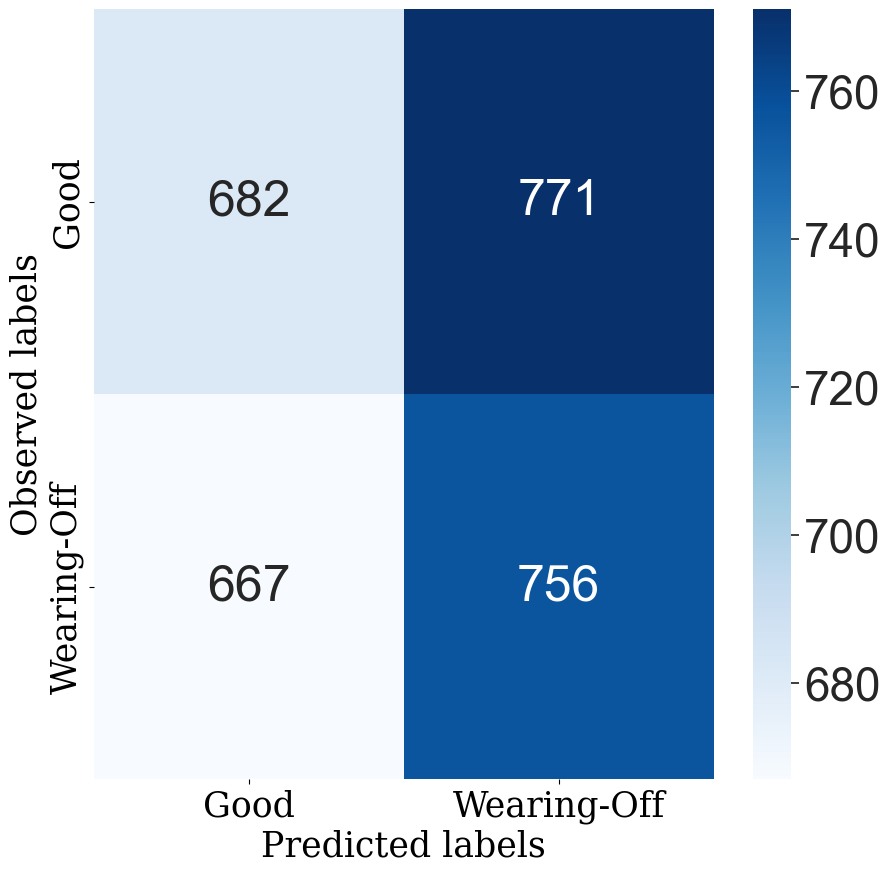


Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1


AttributeError: 'PhotonPipeline' object has no attribute 'classes_'

In [17]:
final_pipeline1 = Hyperpipe('5 - Final Pipeline CI GB',
                    outer_cv = StratifiedKFold(n_splits=5, shuffle=False),
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=False),
                    use_test_set = True,
                    metrics = list(metrics.keys()),
                    best_config_metric='balanced_accuracy',
                    optimizer='sk_opt',
                    optimizer_params={'n_configurations': 30},
                    project_folder=f'./analysis/{dataset_type}{user}_{frequency}',
                    cache_folder=f'./cache/{dataset_type}{user}_{frequency}/',
                    verbosity=1,
                    performance_constraints=[MinimumPerformanceConstraint('balanced_accuracy', 0.75, 'mean')])

tested_methods = Categorical(['RandomUnderSampler', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE'])
final_pipeline1 += PipelineElement('ImbalancedDataTransformer',
                           hyperparameters={ 'method_name': tested_methods })

final_pipeline1 += PipelineElement('GradientBoostingClassifier', 
                            hyperparameters={
                                'loss': ['deviance', 'exponential'],
                                'learning_rate': FloatRange(0.001, 1, 'logspace')
                            })

# Fit hyperpipe
final_pipeline1.fit(X, y)

# Show learning algorithms mean validation results
# print("Comparison on learning algorithms on validation set")
# print(final_pipeline1.results_handler.get_mean_of_best_validation_configs_per_estimator())

# # Show feature importances
# print_feature_importances(final_pipeline1)

# # View CV splits for debugging
# for k,v in final_pipeline1.cross_validation.outer_folds.items():
#     print(v.train_indices)
#     print(v.test_indices)
#     print(len(v.train_indices), len(v.test_indices))
#     print()

# Write other reports to summary file
add_other_report_to_summary(final_pipeline1, with_estimator_comparison=False)

# Show confusion matrix
plot_confusion_matrix_from_pipeline(final_pipeline1)

# Show permutation feature importances
r = final_pipeline1.get_permutation_feature_importances(n_repeats=50, random_state=0, scoring='balanced_accuracy')

for i in r["mean"].argsort()[::-1]:
    # if r["mean"][i] - 2 * r["std"][i] >= 0:
        print(f"{np.array(columns[1:-1])[i]:<8}"
              f" {r['mean'][i]:.3f}"
              f" +/- {r['std'][i]:.3f}"
             )

In [18]:

# Alternative 1: Built-in Feature Importances (Fastest)
print("Method 1: Built-in GradientBoosting Feature Importances")
print("-" * 55)
try:
    # Get the trained estimator
    gb_estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    
    if hasattr(gb_estimator, 'feature_importances_'):
        importances = gb_estimator.feature_importances_
        feature_names = np.array(columns[1:-1])
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        for i, idx in enumerate(indices):
            print(f"{feature_names[idx]:<20} {importances[idx]:.4f}")
    else:
        print("Built-in feature importances not available")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")


Method 1: Built-in GradientBoosting Feature Importances
-------------------------------------------------------
heart_rate           0.5627
time_from_last_drug_taken 0.2488
deep                 0.0906
rem                  0.0386
total                0.0322
awake                0.0164
sleep_efficiency     0.0038
nonrem_percentage    0.0027
light                0.0021
nonrem_total         0.0021
stress_score         0.0000
steps                0.0000




In [19]:
# Alternative 2: Using sklearn's permutation_importance directly
print("Method 2: Sklearn Permutation Importance")
print("-" * 40)
try:
    from sklearn.inspection import permutation_importance
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a subset of data for faster computation (optional)
    # X_sample = X.sample(n=min(1000, len(X)), random_state=42)
    # y_sample = y.loc[X_sample.index]
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        fitted_pipeline, X, y, 
        n_repeats=10,  # Reduced for speed
        random_state=42,
        scoring='balanced_accuracy'
    )
    
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(perm_importance.importances_mean)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {perm_importance.importances_mean[idx]:.4f} "
              f"±{perm_importance.importances_std[idx]:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 2: Sklearn Permutation Importance
----------------------------------------
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [20]:
# Alternative 3: SHAP Values (if you have shap installed)
print("Method 3: SHAP Feature Importance")
print("-" * 35)
try:
    import shap
    
    # Get the fitted pipeline
    fitted_pipeline = final_pipeline1.optimum_pipe
    
    # Use a sample for SHAP (it can be slow on large datasets)
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    
    # Create explainer
    explainer = shap.Explainer(fitted_pipeline, X_sample)
    shap_values = explainer(X_sample)
    
    # Get mean absolute SHAP values as feature importance
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = np.array(columns[1:-1])
    
    # Sort by importance
    indices = np.argsort(feature_importance)[::-1]
    
    for i, idx in enumerate(indices):
        print(f"{feature_names[idx]:<20} {feature_importance[idx]:.4f}")
        
except ImportError:
    print("SHAP not installed. Install with: pip install shap")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 3: SHAP Feature Importance
-----------------------------------
Error: The passed model is not callable and cannot be analyzed directly with the given masker! Model: PhotonPipeline(elements=[('ImbalancedDataTransformer',
                          PipelineElement(config=None, method_name='SMOTE',
                                          name='ImbalancedDataTransformer')),
                         ('GradientBoostingClassifier',
                          PipelineElement(ccp_alpha=0.0,
                                          criterion='friedman_mse', init=None,
                                          learning_rate=0.0014666036255122862,
                                          loss='exponential', max_depth=3,
                                          max_features=None,
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_samples_leaf=1,
                  

In [21]:
# Alternative 4: Simple DataFrame approach for better visualization
print("Method 4: DataFrame Summary")
print("-" * 25)
try:
    import pandas as pd
    
    # Using the original hyperpipe method but organizing results better
    r = final_pipeline1.get_permutation_feature_importances(
        n_repeats=20,  # Reduced for speed
        random_state=0, 
        scoring='balanced_accuracy'
    )
    
    # Create DataFrame for better organization
    importance_df = pd.DataFrame({
        'Feature': np.array(columns[1:-1]),
        'Importance': r["mean"],
        'Std_Dev': r["std"],
        'Lower_Bound': r["mean"] - 2 * r["std"],
        'Upper_Bound': r["mean"] + 2 * r["std"]
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Display top 10
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Show only statistically significant features
    significant_features = importance_df[importance_df['Lower_Bound'] > 0]
    
    if len(significant_features) > 0:
        print(f"\nStatistically Significant Features ({len(significant_features)}):")
        print(significant_features.to_string(index=False, float_format='%.4f'))
    else:
        print("\nNo statistically significant features found")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*60 + "\n")



Method 4: DataFrame Summary
-------------------------

Computing permutation importances. This may take a while.
*****************************************************************************************************
Permutation Importances: Fitting model for outer fold 1
Permutation Importances: Calculating performances for outer fold 1
Error: 'PhotonPipeline' object has no attribute 'classes_'




In [22]:
# Alternative 5: Quick and Simple (Minimal Code)
print("Method 5: Quick and Simple")
print("-" * 25)
try:
    # Just get the built-in importances with minimal code
    estimator = final_pipeline1.optimum_pipe.named_steps['GradientBoostingClassifier']
    importances = estimator.feature_importances_
    features = np.array(columns[1:-1])
    
    # Create sorted list of (importance, feature) tuples
    sorted_features = sorted(zip(importances, features), reverse=True)
    
    print("Feature Importance Ranking:")
    for i, (importance, feature) in enumerate(sorted_features[:15], 1):
        print(f"{i:2d}. {feature:<20} {importance:.4f}")
        
except Exception as e:
    print(f"Error: {e}")

Method 5: Quick and Simple
-------------------------
Feature Importance Ranking:
 1. heart_rate           0.5454
 2. time_from_last_drug_taken 0.2603
 3. deep                 0.0819
 4. total                0.0538
 5. rem                  0.0278
 6. awake                0.0231
 7. sleep_efficiency     0.0038
 8. nonrem_percentage    0.0024
 9. nonrem_total         0.0009
10. light                0.0005
11. stress_score         0.0000
12. steps                0.0000
